In [1]:
import sys
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc

import numpy as np
import mplscience

import anndata as ad

In [2]:
adata = ad.read_h5ad("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/shaffer_23024_2000.h5ad")
adata

AnnData object with n_obs × n_vars = 23024 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_lineage', 'nFeature_lineage', 'percent.mt', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.4', 'OG_condition', 'RNA_snn_res.0.3', 'Lineage', 'keep', 'clone_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
import numpy as np

# Load the custom embedding
embedding = np.load("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/scBaseEncoderFeat_Z_bs100_tau0.5.npy")

# Check that embedding has shape (23024, X) where 23024 = adata.n_obs
assert embedding.shape[0] == adata.n_obs, \
    "Embedding rows do not match the number of cells in adata."

# Store the embedding in adata.obsm under a custom key
adata.obsm["X_lcl"] = embedding


In [4]:
import pandas as pd

# Export cell (obs) names
adata.obs_names.to_series().to_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/obs_names_python.csv", header=False)

# Export gene (var) names
adata.var_names.to_series().to_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/var_names_python.csv", header=False)

Run Hotspot

In [5]:
adata

AnnData object with n_obs × n_vars = 23024 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_lineage', 'nFeature_lineage', 'percent.mt', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.4', 'OG_condition', 'RNA_snn_res.0.3', 'Lineage', 'keep', 'clone_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_lcl'
    varm: 'PCs'

In [6]:
import scipy.io
import numpy as np
import anndata
from scipy.sparse import coo_matrix

# Read the matrix from the .mtx file
mtx = scipy.io.mmread("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/counts_matrix.mtx")  # returns a coo_matrix

# Convert to CSR for efficient row slicing
mtx_csr = mtx.tocsr()

# Check shape
print(mtx_csr.shape, adata.shape)

# Since we carefully ordered cells and genes in R,
# the shape should match adata.n_vars x adata.n_obs if the matrix is genes x cells.
# But we need to align this with how AnnData stores data: 
# in AnnData, X is shape (n_obs x n_vars).

# If the matrix is (genes x cells) we need to transpose it to (cells x genes)
raw_counts = mtx_csr.transpose()

# Now raw_counts should have shape (n_obs, n_vars)
print(raw_counts.shape, adata.shape)  
# ideally these match exactly now.

# Store in layers
adata.layers["counts"] = raw_counts

(2000, 23024) (23024, 2000)
(23024, 2000) (23024, 2000)


In [7]:
adata.X = adata.layers["counts"]

In [8]:
import numpy as np

# Sum expression across all cells (axis=0 => sum per gene)
gene_sums = np.array(adata.X.sum(axis=0)).ravel()

# Filter to keep genes with a nonzero sum
genes_to_keep = gene_sums > 0

# Subset the AnnData to these genes
adata = adata[:, genes_to_keep].copy()

In [9]:
adata.layers["counts_csc"] = adata.X.tocsc()

In [10]:
adata

AnnData object with n_obs × n_vars = 23024 × 1949
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_lineage', 'nFeature_lineage', 'percent.mt', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.4', 'OG_condition', 'RNA_snn_res.0.3', 'Lineage', 'keep', 'clone_id'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap', 'X_lcl'
    varm: 'PCs'
    layers: 'counts', 'counts_csc'

In [11]:
# Create the Hotspot object with latent embeddings and normalized data

hs = hotspot.Hotspot(
    adata,
    layer_key="counts_csc",
    model="danb",
    latent_obsm_key="X_lcl"
)

In [12]:
# Create the neighborhood graph
hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [13]:
# Determine informative genes
hs_results = hs.compute_autocorrelations(jobs=1)
print(hs_results.head(15))

100%|██████████| 1949/1949 [00:01<00:00, 1049.71it/s]

                   C            Z  Pval  FDR
Gene                                        
PMEL        0.594096  1520.665527   0.0  0.0
MLANA       0.596835  1257.659912   0.0  0.0
VGF         0.325897  1009.782654   0.0  0.0
LHFPL3-AS1  0.403165   992.207153   0.0  0.0
PRDX1       0.498588   969.437378   0.0  0.0
MIA         0.426084   922.001587   0.0  0.0
SAT1        0.320690   911.734558   0.0  0.0
GAS5        0.296943   786.384460   0.0  0.0
AKR1A1      0.352035   672.641968   0.0  0.0
DCT         0.287585   593.710327   0.0  0.0
FRMD4B      0.343975   574.968140   0.0  0.0
GPM6B       0.394022   572.291016   0.0  0.0
H2AFZ       0.430038   537.066528   0.0  0.0
CAPG        0.359212   533.038330   0.0  0.0
TYRP1       0.093616   522.566223   0.0  0.0


In [14]:
print(hs_results.tail(15))

                   C         Z      Pval       FDR
Gene                                              
AC073878.1 -0.000753 -0.497166  0.690464  0.695460
GREM1      -0.000436 -0.517944  0.697751  0.702436
XIRP1      -0.000243 -0.534900  0.703640  0.708000
CCL11      -0.000284 -0.539330  0.705171  0.709173
LINC02244  -0.000791 -0.543664  0.706664  0.710308
MAP3K19    -0.000321 -0.546450  0.707622  0.710904
AL365226.2 -0.000460 -0.553082  0.709896  0.712822
KCNQ1OT1   -0.000686 -0.557880  0.711537  0.714102
LINC01640  -0.000570 -0.578699  0.718604  0.720823
SSMEM1     -0.001026 -0.634474  0.737114  0.739010
HLA-DRB1   -0.000699 -0.734340  0.768629  0.770210
ANGPTL1    -0.001251 -0.754800  0.774816  0.776010
CAMK1G     -0.000580 -0.849103  0.802088  0.802912
RAD21-AS1  -0.001610 -1.052511  0.853717  0.854156
DCDC2C     -0.000921 -1.269840  0.897929  0.897929


In [15]:
import pandas as pd

# Assuming df is your DataFrame
hs_results.to_csv('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/Writeup7_LCL_hotspot_autocorrelations.csv')  

In [16]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=1)

Computing pair-wise local correlation on 500 features...


100%|██████████| 124750/124750 [01:23<00:00, 1485.65it/s]


In [17]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

Module
-1     120
 2      88
 1      80
 3      49
 4      42
 5      33
 6      19
 9      19
 8      18
 10     16
 7      16
Name: count, dtype: int64

In [18]:
modules.to_csv('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/Writeup7_LCL_hotspot_module-clustering.csv')


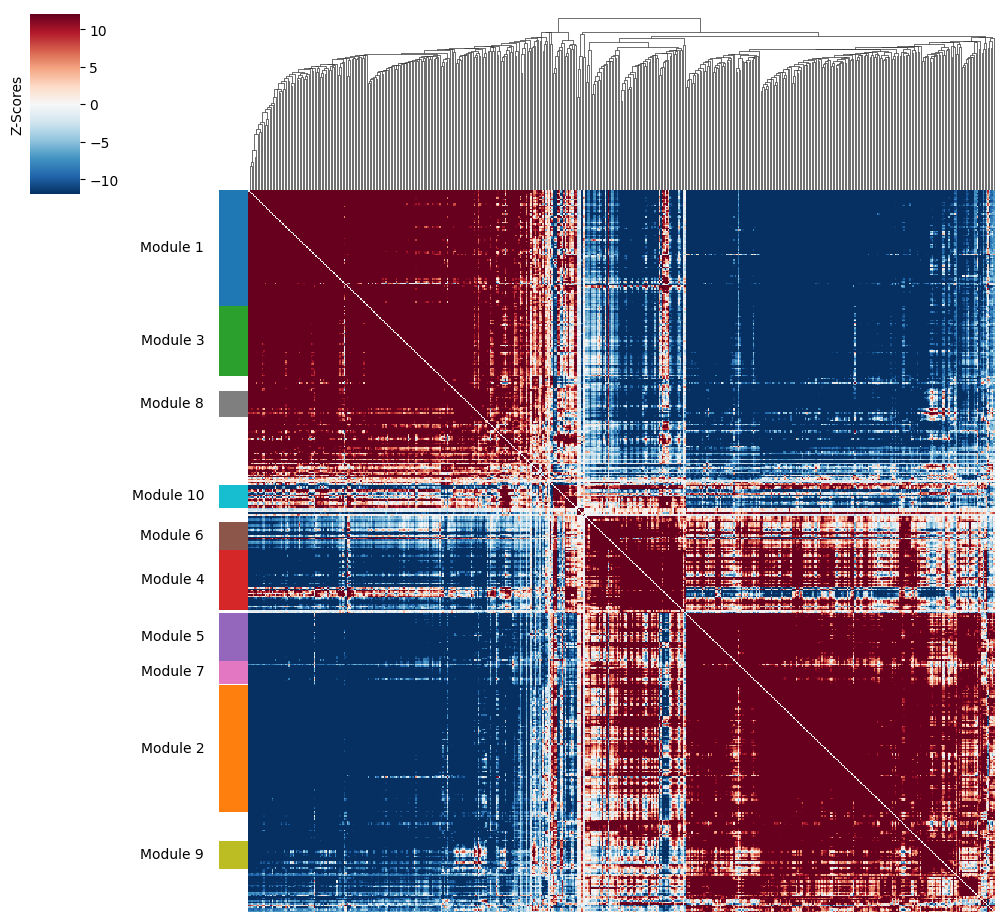

In [19]:
hs.plot_local_correlations(vmin=-12, vmax=12)

Summary module scores

In [20]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 10 modules...


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


,1,2,3,4,5,6,7,8,9,10
dabtram_AAACCCAGTTTACCTT-1,-5.812523,4.003077,-2.541038,-0.049210,1.233482,-0.149273,0.913235,-1.052402,0.585285,-0.846947
dabtram_AAACCCATCACGTCCT-1,-5.379952,3.920879,-1.689946,-0.032595,1.295978,-0.015918,0.845458,-0.837567,0.881300,-0.668566
dabtram_AAACCCATCCTCTTTC-1,-3.092391,1.562138,-0.544335,-0.299572,0.041462,0.024347,-0.366567,0.376568,1.553340,-0.074842
dabtram_AAACGAAAGGAGAGTA-1,-5.893048,2.507522,-1.391557,-0.234099,7.405883,1.051996,7.759534,-1.712124,-0.038711,-0.003547
dabtram_AAACGCTCAAACGTGG-1,-5.558502,4.281629,-3.407899,-0.967865,3.542473,-0.543612,-0.326346,-1.294231,1.852013,-1.041411


In [21]:
module_scores.to_csv('/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/Writeup7_LCL_hotspot_module-scores.csv')

In [22]:
adata.obs["OG_condition"] = adata.obs["OG_condition"].astype("category")

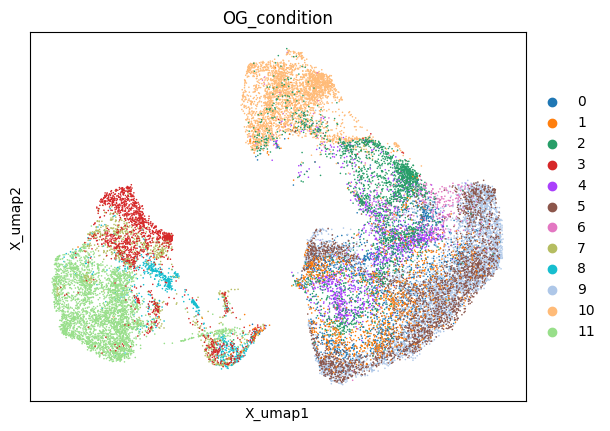

In [23]:
sc.pl.embedding(adata, basis='X_umap', color='OG_condition') 

In [24]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

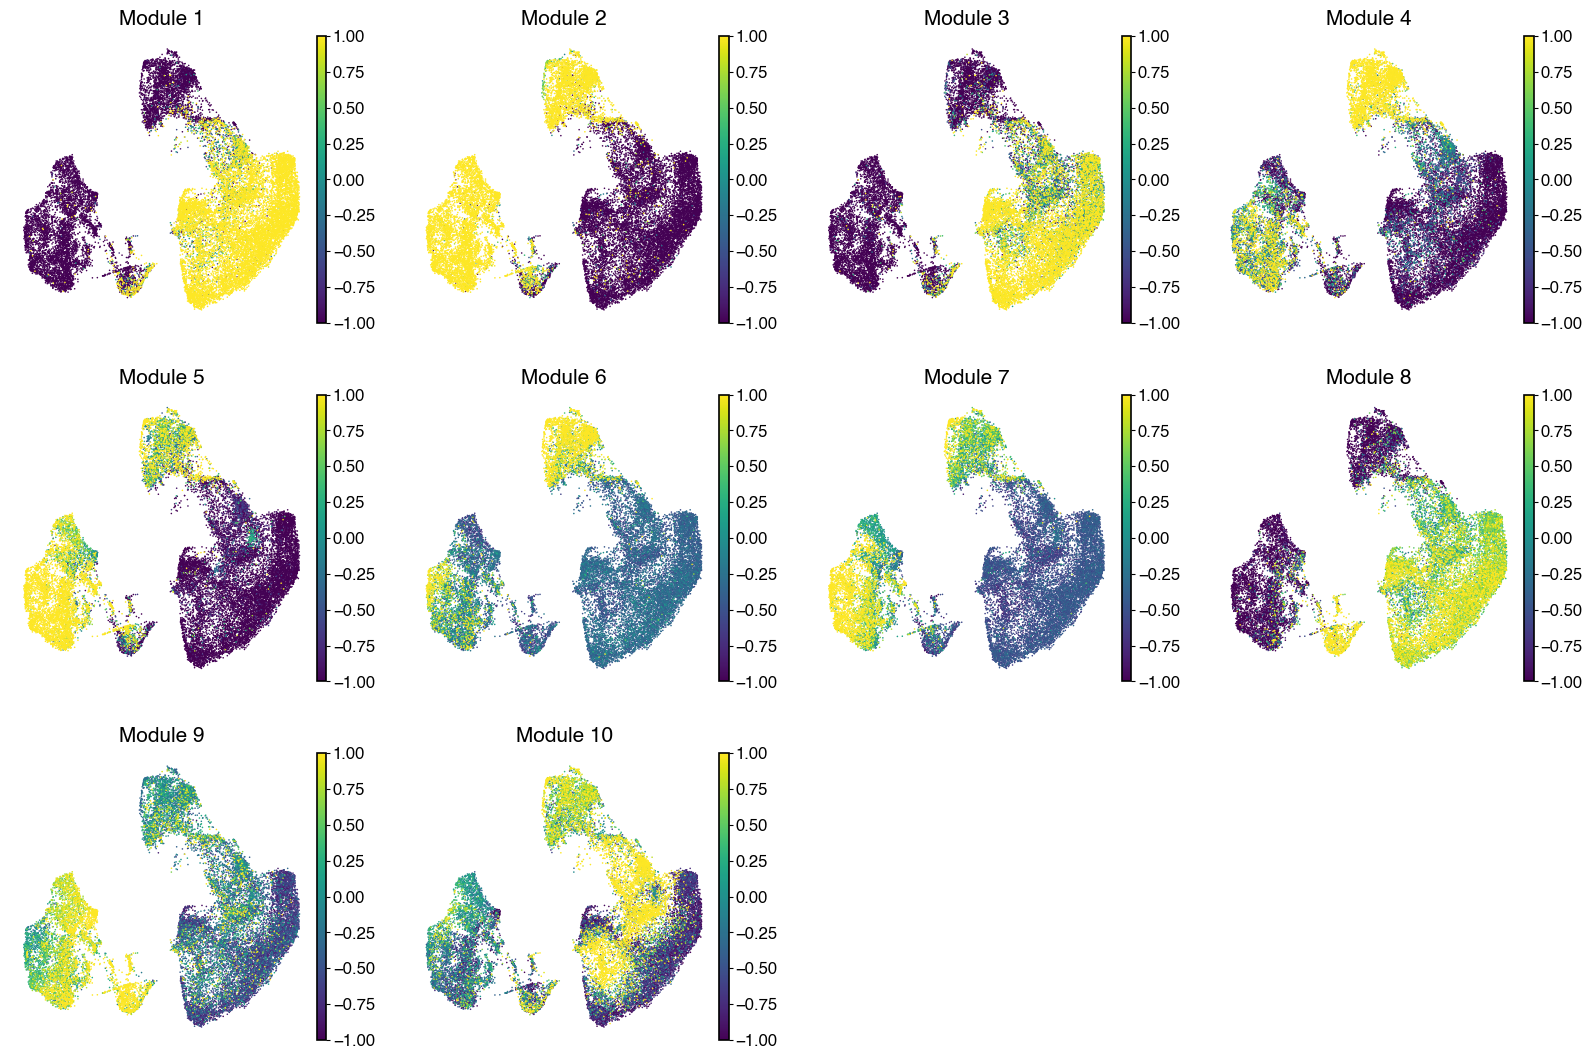

In [25]:
with mplscience.style_context():
    sc.pl.embedding(adata,  basis='X_umap', color=module_cols, frameon=False, vmin=-1, vmax=1)

In [26]:
adata

AnnData object with n_obs × n_vars = 23024 × 1949
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_lineage', 'nFeature_lineage', 'percent.mt', 'percent.rb', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.5', 'seurat_clusters', 'RNA_snn_res.0.4', 'OG_condition', 'RNA_snn_res.0.3', 'Lineage', 'keep', 'clone_id', 'Module 1', 'Module 2', 'Module 3', 'Module 4', 'Module 5', 'Module 6', 'Module 7', 'Module 8', 'Module 9', 'Module 10'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'OG_condition_colors'
    obsm: 'X_pca', 'X_umap', 'X_lcl'
    varm: 'PCs'
    layers: 'counts', 'counts_csc'

In [27]:
# Remove columns from adata.var
adata.var.drop(
    columns=[
        'vst.mean', 
        'vst.variance', 
        'vst.variance.expected', 
        'vst.variance.standardized', 
        'vst.variable'
    ], 
    inplace=True,
    errors='ignore'  # ignore if some columns don't exist
)

# Remove "OG_condition_colors" from adata.uns
del adata.uns["OG_condition_colors"]  # or adata.uns.pop("OG_condition_colors", None)

In [28]:
del adata.raw


In [29]:
# Suppose your real expression matrix is in adata.layers["counts"] 
# Make that your main X
adata.X = adata.layers["counts"].copy()

# Remove raw if you do not need it
if adata.raw is not None:
    del adata.raw

# Remove any other layers that might look like assays
for layer_name in ["counts", "counts_csc"]:
    if layer_name in adata.layers:
        del adata.layers[layer_name]

In [30]:
for layer_name in adata.layers:
    print(layer_name, adata.layers[layer_name].shape)

if adata.raw is not None:
    print("adata.raw shape:", adata.raw.X.shape)


In [31]:
from scipy.sparse import csc_matrix, csr_matrix

# Convert if it's CSC
if isinstance(adata.X, csc_matrix):
    adata.X = adata.X.tocsr()

In [32]:
import pandas as pd

# Convert OG_condition to categorical (string labels)
adata.obs["OG_condition"] = adata.obs.index.str.split("_").str[0].astype("category")

In [33]:
# Save obs metadata to CSV
adata.obs.to_csv("/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/adata_obs_backup.csv")


In [34]:
adata.obs = pd.DataFrame(index=adata.obs.index)  # Keep only the cell barcodes

In [35]:
adata

AnnData object with n_obs × n_vars = 23024 × 1949
    obsm: 'X_pca', 'X_umap', 'X_lcl'
    varm: 'PCs'

In [36]:
adata.write_h5ad(
    "/Users/kevinlin/Library/CloudStorage/Dropbox/Collaboration-and-People/Joshua/out/kevin/Writeup7_joshua-results_dylan/adata_with_lcl.h5ad",
    compression='gzip', 
    compression_opts=9
)